# Training Kalman Filter for Results - 12 Feb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *
from meteo_imp.gaussian import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastcore.foundation import L
from fastcore.foundation import patch
from pathlib import Path, PosixPath

from meteo_imp.kalman.fastai import show_results
import pandas as pd
import numpy as np
import torch
import random
from pyprojroot import here

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from IPython.display import Image

from tqdm.auto import tqdm

In [ ]:
from fastcore.basics import *

In [ ]:
reset_seed()

In [ ]:
hai = pd.read_parquet(hai_big_path)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
base = here("analysis/results/trained_13feb")

In [ ]:
base.mkdir(exist_ok=True)

In [ ]:
@patch
def add_end(self: PosixPath, end): return self.parent / (self.name + end)

In [ ]:
def train_or_load(model, dls, lr, n, path, keep=True):
    save_models = SaveModelsBatch(times_epoch=5)
    csv_logger = CSVLogger(path.add_end("log.csv"))
    learn = Learner(dls, model, KalmanLoss(only_gap=True), cbs = [Float64Callback, save_models, csv_logger], metrics=rmse_gap) 
    items = random.choices(dls.valid.items, k=4) 
    if path.add_end(".pickle").exists() and keep:
        learn.model = torch.load(path.add_end(".pickle"))
        display(csv_logger.read_log())
        plot = Image(filename=path.add_end("_loss_plot.png"))
        display(plot)
    else:
        learn.fit(lr, n)
        
        torch.save(learn.model, path.add_end(".pickle"))
        learn.recorder.plot_loss()
        plt.savefig(path.add_end("_loss_plot.png"))
    return learn, items                           

In [ ]:
def metric_valid(learn, dls=None):
    nrmse = []
    losses = []
    dls = ifnone(dls, learn.dls.valid)
    for input, target in tqdm(dls):
        pred = learn.model(input)
        nrmse.append(learn.metrics[0](pred, target))
        losses.append(learn.loss_func(pred, target).item())
    metric = pd.DataFrame({'loss': losses, 'rmse': nrmse})
    return metric.agg(['mean', 'std'])

In [ ]:
hai.columns

Index(['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS', 'PA', 'P', 'SWC', 'TS'], dtype='object')

## Generic model | gap len 3-336 | gap 1 random 

In [ ]:
dls_A1v = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = gen_var_sel(list(hai.columns), n_var=1),
    block_len=100+336,
    gap_len=gen_gap_len(12, 336),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5).cpu()

In [ ]:
model_A1v = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    pred_only_gap=True)

In [ ]:
model_A1v.B.shape

torch.Size([1, 18, 14])

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,196.765350,163.493486,0.579074,44:01
1,1,138.298704,123.299909,0.490741,44:31
2,2,113.640141,116.746793,0.488059,42:31


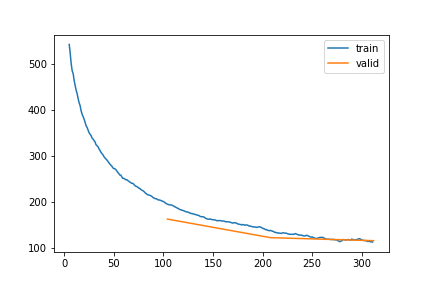

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 3, 1e-3, base / "1_gap_varying_12-336_v1")

epoch,train_loss,valid_loss,rmse_gap,time
0,196.765350,163.493486,0.579074,44:01
1,138.298704,123.299909,0.490741,44:31
2,113.640141,116.746793,0.488059,42:31


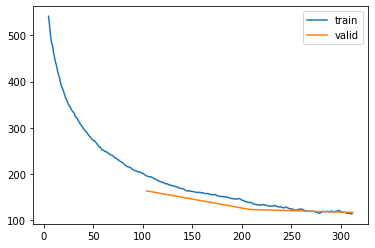

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 3, 1e-5, base / "1_gap_varying_12-336_v2")

In [ ]:
show_results(learn_A1v)

[MeteoImpItem(i=451, shift=11, var_sel=['WS'], gap_len=328), MeteoImpItem(i=455, shift=-70, var_sel=['TA'], gap_len=326), MeteoImpItem(i=501, shift=23, var_sel=['SW_IN'], gap_len=322)]


alt.HConcatChart(...)

In [ ]:
metric_valid(learn_A1v)

  0%|          | 0/26 [00:00<?, ?it/s]

,loss,rmse
mean,96.871684,0.428096
std,38.539188,0.113949


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,84.676688,91.879223,0.42373,30:58


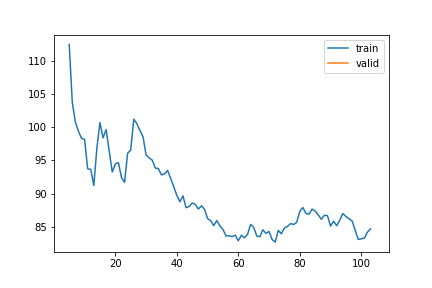

In [ ]:
learn_A1v, items_A1v = train_or_load(learn_A1v.model, dls_A1v, 1, 5e-6, base / "1_gap_varying_3-336_v2")

## 1 var gap - varying 336 - No Control

In [ ]:
model_A1v_nc = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    pred_only_gap=True,
    use_control=False
)

epoch,train_loss,valid_loss,rmse_gap,time
0,225.831814,196.530018,0.679575,42:16
1,181.730136,179.931006,0.622102,42:47
2,174.721447,175.969022,0.592775,41:48


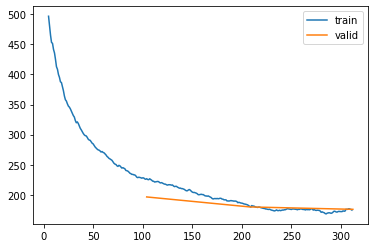

In [ ]:
learn_A1v_nc, items_A1v_nc = train_or_load(model_A1v_nc, dls_A1v, 3, 1e-3, base / "1_gap_varying_336_no_control_v1")

## All variables - 30 all

In [ ]:
dls_Aa = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = list(hai.columns),
    block_len=120,
    gap_len=30,
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5
).cpu()

In [ ]:
dls_Aa = imp_dataloader(hai, hai_era, var_sel = list(hai.columns), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Aa = learn_A1v.model.copy()

In [ ]:
metric_valid(learn_A1v, dls=dls_Aa.valid)

  0%|          | 0/190 [00:00<?, ?it/s]

,loss,rmse
mean,310.588176,0.908583
std,56.248472,0.204352


epoch,train_loss,valid_loss,rmse_gap,time
0,68.115461,62.590038,0.419928,31:16
1,24.302401,30.411800,0.399196,31:34
2,11.095821,15.858787,0.388143,31:03


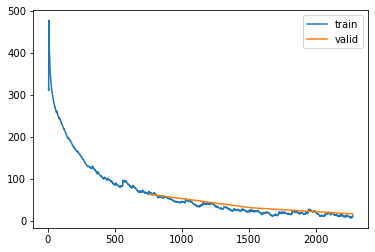

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 3, 3e-4, base / "All_gap_all_30_v1")

## Fine tuning

### Finetune gap length

  0%|          | 0/4 [00:00<?, ?it/s]

Gap len: 6


  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,1.247630,0.234464
std,3.109537,0.123313


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,2.278421,1.701985,0.248359,01:33
1,1,1.197995,1.562936,0.247491,01:30
2,2,0.676090,1.439395,0.245816,01:28


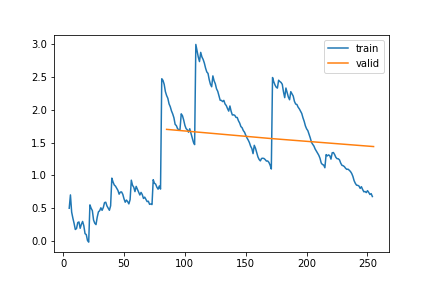

Gap len: 24


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,13.170145,0.378981
std,9.782837,0.108107


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,8.605524,9.680723,0.346301,02:09
1,1,8.196774,9.658409,0.345941,02:03
2,2,7.940351,9.333798,0.343399,02:04


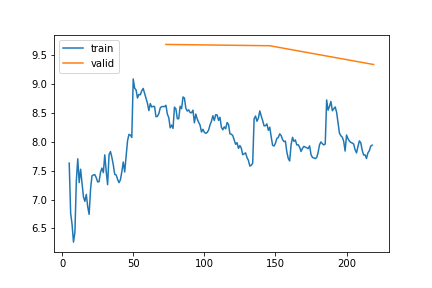

Gap len: 48


  0%|          | 0/16 [00:00<?, ?it/s]

,loss,rmse
mean,23.275539,0.386880
std,8.201757,0.079038


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,20.522270,28.226681,0.428597,02:44
1,1,20.123038,27.948954,0.425583,02:38
2,2,21.275250,27.780100,0.422899,02:39


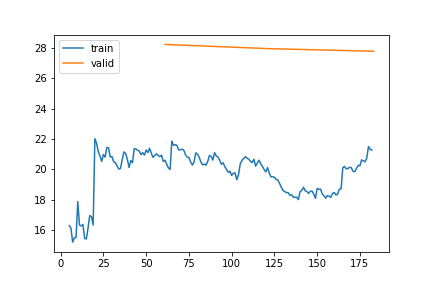

Gap len: 336


  0%|          | 0/6 [00:00<?, ?it/s]

,loss,rmse
mean,162.622499,0.430899
std,97.689637,0.138170


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,158.012086,189.406813,0.460826,06:31
1,1,158.148799,192.724921,0.462467,06:20
2,2,157.097036,192.511927,0.461974,06:43


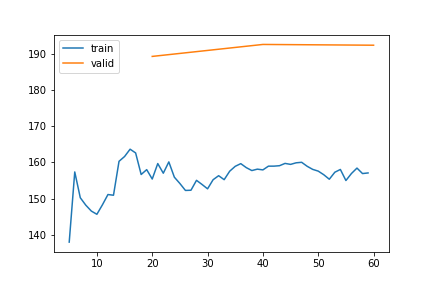

In [ ]:
gap_models = {}
gap_dls = {}
gap_learn = {}
gap_items = {}
for gap_len in tqdm([6,24,48,7*48]):
    print(f"Gap len: {gap_len}")
    gap_dls[gap_len] = imp_dataloader(hai, hai_era, var_sel = gen_var_sel(list(hai.columns), n_var=1), block_len=gap_len+100, gap_len=gap_len, bs=20, control_lags=[1], n_rep=1, shifts=gen_shifts(50)).cpu()
    gap_models[gap_len] = learn_A1v.model.copy()
    display(metric_valid(learn_A1v, dls=gap_dls[gap_len].valid))
    gap_learn[gap_len], gap_items[gap_len] = train_or_load(gap_models[gap_len], gap_dls[gap_len], 3, 2e-5, base / f"gap_1_any_var_gap_len_{gap_len}_v1.pickle")
    plt.show()
    

### Fine tune Variable | gap only for one variable | gap len 3-336

fine tune the model to only one variable

In [ ]:
from fastcore.basics import *

In [ ]:
from IPython.display import HTML

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in tqdm(list(hai.columns)):
    display(HTML(f"<h3> {var} </h3>"))
    spec_dls[var] = imp_dataloader(hai, hai_era, var_sel = var, block_len=100+336, gap_len=gen_gap_len(3, 336), bs=20, control_lags=[1], n_rep=1, shifts=gen_shifts(50)).cpu()
    spec_models[var] = learn_A1v.model.copy()
    print("Metrics of generic model for only one variable")
    display(metric_valid(learn_A1v, dls=spec_dls[var].valid))
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 2, 1e-5, base / f"{var}_specialized_gap_3-336_v1.pickle")
    plt.show()

do some additional training for `LW_IN` and `SW_IN`

In [ ]:
spec_learn2 = {}
for var in tqdm(['SW_IN', 'LW_IN']):
    print(var)
    print(metric_valid(spec_learn[var].model, dls=spec_dls[var].valid))
    spec_learn2[var], _ = train_or_load(spec_learn[var].model, spec_dls[var], 3, 2e-5, base / f"{var}_specialized_gap_3-336_v3.pickle")
    plt.show()
    